In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import *

# datatype definitions
ndarray = np.ndarray

In [2]:
#====================================================================
# Datatype for stars to hold their mass, position, and velocity
#====================================================================
class Star:
    
    def __init__(self, M: float, pos_i : ndarray, vel_i : ndarray):
        self.M = M
        self.pos = pos_i
        self.vel = vel_i

#====================================================================
# Binary star system class: stores two stars with the same mass
# and has a function that progresses the orbits according to the
# laws of motion for a same-mass binary system.
#====================================================================
class Binary:
    
    def __init__(self, separation : float, M : float, vel1_i : ndarray, vel2_i : ndarray):
        
        r = separation / 2
        self.M = M
        self.star1 = Star(M, np.array([r, 0]), vel1_i)
        self.star2 = Star(M, np.array([-r, 0]), vel2_i)
    
    #Private:
    def __vectorize(self) -> ndarray:
        """
        Puts all of the data about the two stars into a nicely formatted vector
        """
    
        return np.array([self.star1.pos[0], self.star1.pos[1], self.star2.pos[0], self.star2.pos[1],
                         self.star1.vel[0], self.star1.vel[1], self.star2.vel[0], self.star2.vel[1]])
    
    def __unvectorize(self, vector : ndarray) -> None:
        """
        Takes a nicely formatted vector and sets all of the Binary's data to the values
        Basically the inverse of __vectorize
        """   
        self.star1.pos[0] = vector[0]
        self.star1.pos[1] = vector[1]
        self.star2.pos[0] = vector[2]
        self.star2.pos[1] = vector[3]
        self.star1.vel[0] = vector[4]
        self.star1.vel[1] = vector[5]
        self.star2.vel[0] = vector[6]
        self.star2.vel[1] = vector[7]
    
    def __offsetDifferential(self, offset : float | ndarray) -> ndarray:
        """
        Takes the vectorized data and applies an offset 
        Returns the derivative of each offset datum
        """ 
        # offset data
        offset_vector = self.__vectorize() + offset
        
        # distance between the stars
        r = np.sqrt((self.star1.pos[0] - self.star2.pos[0])**2 + (self.star1.pos[1] - self.star2.pos[1])**2)
        
        # position derivatives are just velocities, which are the second half of the vectorized data
        position_differential = offset_vector[4:]
        
        # velocity derivatives are computed using the positions, which are the first half of the vectorized data
        velocity_differential = -G*self.M/(r*r*r) * offset_vector[0:4]
        
        differential = np.concatenate((position_differential, velocity_differential), axis=None)
        
        return differential
    
    def __rk4(self, dt : float) -> ndarray:
        """
        Takes a time step over which to compute the Runge-Kutta method
        Returns a vector of the Binary's data after the provided time step
        """
        
        if dt < 0:
            raise ValueError("step size must be positive")
        
        k1 = self.__offsetDifferential(0) * dt
        k2 = self.__offsetDifferential(0.5*k1) * dt
        k3 = self.__offsetDifferential(0.5*k2) * dt
        k4 = self.__offsetDifferential(k3) * dt
        
        return self.__vectorize() + (k1 + 2*k2 + 2*k3 + k4)/6
    
    # Public:
    def orbitStep(self, dt : float) -> None:
        """
        Updates the Binary's data to the values obtained by taking one step of the rk4 method
        """
        # rk4 will return a formatted vector that unvectorize uses to update the Binary's data
        self.__unvectorize(self.__rk4(dt))

In [3]:
#====================================================================
# Parameters:
# - B  : a Binary star system object
# - dt : the time step you wish to compute the rk4 method over
# Returns:
#  The positions of the two stars after one time step
#====================================================================
def orbitStep(B : Binary, dt : float) -> ndarray:
    
    B.orbitStep(dt)
    return np.array([B.star1.pos[0], B.star1.pos[1], B.star2.pos[0], B.star2.pos[1]])

In order to have eccentricity zero, the stars must orbit the barycenter in a circle. In order for this to be possible, the velocity must be a constant

$$v = \frac{1}{2}\sqrt{\frac{GM}{r}}$$

I'm pretty sure the division by two comes from the fact that the stars have equal mass, but honestly I found this by trial and error and every time I tried to give the stars different masses everything broke so I couldn't really test $\frac{M_1}{M_2} \rightarrow 0$, but in that limit it should go to $v = \sqrt{\frac{GM}{r}}$.

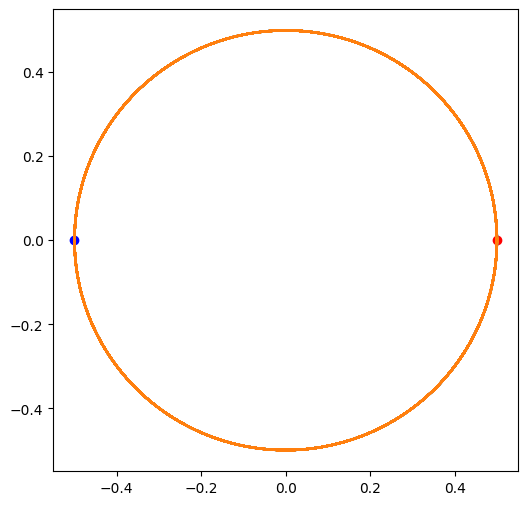

[0.  0.5]


In [5]:
# We define G, the mass of both stars, and the distance between the stars to be 1 for simplicity of computation
G = 1
Mass = 1
separation = 1

# Applying the velocity formula
initial_velocity = np.array([0, 0.5])

# Time variables
t = 0
tend = (2*np.pi) * 100
dt = 0.1

# Maximum values |x| and |y| that we will simulate
simulation_limit = 2

B = Binary(separation, Mass, initial_velocity.copy(), -initial_velocity.copy())

X1 = [B.star1.pos[0]]
Y1 = [B.star1.pos[1]]
X2 = [B.star2.pos[0]]
Y2 = [B.star2.pos[1]]

# Simulate up to tend (which is set to 100 orbits)
while t < tend:
    if t + dt > tend:
        dt = tend - t
    t += dt
    
    x1, y1, x2, y2 = orbitStep(B, dt)
    
    # This code should not be executed. If it is, something broke.
    if abs(x1) > simulation_limit or abs(y1) > simulation_limit or abs(x2) > simulation_limit or abs(y2) > simulation_limit:
        print("oopsies, looks like we exploded")
        break
        
    X1.append(x1)
    Y1.append(y1)
    X2.append(x2)
    Y2.append(y2)
    
# Plotting
plt.plot(X1, Y1)
plt.plot(X2, Y2)
plt.scatter(X1[0], Y1[0], color='red')
plt.scatter(X2[0], Y2[0], color='blue')
plt.gcf().set_size_inches(6, 6)
plt.show()

print(initial_velocity)